# Utility Functions

In [2]:
import numpy as np


def sum_with_error(eigs, r, error_mag):
    """
    Compute sums[i] = Tr(rho^i) + noise in [-error_mag, +error_mag].
    sums[0] = 1 as a convention for Newton-Girard usage.
    """
    sums = [1.0]
    for i in range(1, r + 1):
        true_val = sum(lam**i for lam in eigs)
        error = 2 * error_mag * np.random.rand() - error_mag
        sums.append(true_val + error)
    return sums


def cal_coefficient(sums, r):
    """
    Calculate Newton-Girard coefficients a[0..r].
    a[0] = 1, a[1] = sums[1], etc.
    """
    a = [1.0, sums[1]]
    for i in range(2, r + 1):
        v = 0.0
        for j in range(1, i + 1):
            v += ((-1)**(j-1)) * a[i - j] * sums[j]
        a.append(v / i)
    return a


def cal_power_trace(sums, eigen_values, a, K, r):
    """
    Use Newton-Girard to expand sums up to r+K.
    Return v1 (Tr(rho^(r+K)) estimated) and v2 (exact).
    """
    v1 = 0.0
    for i in range(1, K + 1):
        tmp = 0.0
        for j in range(1, r + 1):
            tmp += ((-1)**(j-1)) * sums[r - j + i] * a[j]
        v1 = tmp
        sums.append(tmp)
    v2 = sum(lam**(r + K) for lam in eigen_values)
    return v1, v2


def gen_arithmetic(max_min_gap, size):
    """
    Generate an eigenvalue vector in arithmetic progression (size = 'size'),
    where (max_value - min_value) = max_min_gap.
    If it's not possible to construct such a distribution, return None.

    Example:
    --------
    gen_arithmetic(0, 4) -> [0.25, 0.25, 0.25, 0.25]
    gen_arithmetic(0.5, 4) -> might look like [0.5, 0.3333, 0.1667, 0.0], scaled to sum=1
    """
    if max_min_gap > 2 / size or max_min_gap > 2 - 2 / size:
        print("[gen_arithmetic] Error: Cannot satisfy the given max_min_gap.")
        return None
    eigs = np.linspace(1/size + max_min_gap/2, 1/size - max_min_gap/2, size)
    s = np.sum(eigs)
    if s == 0:
        return None
    eigs /= s
    return eigs


def gen_geometric(max_min_ratio, size):
    """
    Generate an eigenvalue vector in geometric progression (size = 'size'),
    where (max_value / min_value) = max_min_ratio.
    If it's not possible, return None.

    Example:
    --------
    gen_geometric(2, 4) -> might look like [0.4, 0.2667, 0.2, 0.1333], scaled to sum=1
    """
    if max_min_ratio <= 1:
        print("[gen_geometric] Error: max_min_ratio must be > 1.")
        return None
    r = max_min_ratio ** (1 / (1 - size))
    numerator = (1 - r)
    denominator = (1 - r**size)
    if denominator == 0:
        return None
    a_1 = numerator / denominator
    a_size = numerator * (r**(size - 1)) / denominator
    eigs = np.geomspace(a_1, a_size, num=size)
    s = np.sum(eigs)
    if s == 0:
        return None
    eigs /= s
    return eigs


def gen_almost_one(max_eigenvalue, size):
    """
    Generate an eigenvalue distribution of length `size` where:
      - One eigenvalue is chosen in the range [0.999, 0.999999].
      - The rest (size-1) eigenvalues share 1 - that large value randomly.
    Returns:
      A NumPy array of shape (size,) that sums to 1.
    """
    if size < 2:
        raise ValueError("size must be at least 2 for gen_almost_one")
    big_val = np.random.uniform(
        0.999, 0.999999) if max_eigenvalue is not None else max_eigenvalue
    remain = 1.0 - big_val
    other = np.random.rand(size - 1)
    other_sum = np.sum(other)
    if other_sum > 0:
        other = other / other_sum * remain
    else:
        other = np.zeros(size - 1)
    eigs = np.concatenate(([big_val], other))
    eigs = np.sort(eigs)[::-1]
    return eigs


def gen_random(size):
    """
    Generate a random eigenvalue vector (size = 'size'), summing to 1, all >= 0.
    This method splits [0,1] in random ratios to create eigenvalues.
    """
    diff_values = np.random.rand(size - 1)
    eigs = []
    v = 1.0
    for d in diff_values:
        eigs.append(v * d)
        v *= (1 - d)
    eigs.append(v)
    eigs = np.array(eigs)
    s = np.sum(eigs)
    if s == 0:
        return None
    eigs /= s
    return eigs


# Almost_one

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
from collections import defaultdict

from utils import gen_almost_one, sum_with_error, cal_coefficient, cal_power_trace


def experiment_almost_one_A(r_vals, k_vals, eps_vals, max_eig=0.999, trials=1):
    """
    Experiment A:
    For each r in r_vals,
        for each k in k_vals,
            for each eps in eps_vals,
    we do 'trials' runs with gen_almost_one(max_eig, r).
    Then measure the absolute error of Tr(rho^k) for each run and average.

    Returns: a list of dict rows: 
      { index, r, K, eps, mean_error }.
    """
    results = []
    index_count = 0

    for r in r_vals:
        # 한 번만 eigenvalue 생성 (혹은 trial마다 새로 생성해도 됨)
        eigs = gen_almost_one(max_eig, r)
        if eigs is None or not np.isclose(np.sum(eigs), 1.0, atol=1e-8):
            print(
                f"[experiment_almost_one_A] Warning: gen_almost_one failed (r={r})")
            continue

        for k in k_vals:
            for eps in eps_vals:
                abs_errs = []
                for _ in range(trials):
                    tilde_r = r
                    # tilde_r = math.ceil(math.log(k / eps))
                    # tilde_r = math.ceil(math.log(k / eps) / math.log(math.log(k / eps)))
                    sums = sum_with_error(eigs, tilde_r, eps)
                    a = cal_coefficient(sums, tilde_r)
                    v1, v2 = cal_power_trace(sums, eigs, a, k, tilde_r)
                    abs_err = abs(v1 - v2)
                    abs_errs.append(abs_err)

                mean_err = np.mean(abs_errs)
                row = {
                    "index": index_count,
                    "r": r,
                    "K": k,
                    "eps": eps,
                    "mean_error": mean_err
                }
                results.append(row)
                index_count += 1

    return results


def experiment_almost_one_B(r, k_vals, max_eig_vals, eps=1e-6, trials=1):
    """
    Experiment B:
    Fix rank r and eps,
    vary k in k_vals,
    vary max_eig in max_eig_vals (the largest eigenvalue),
    generate an 'almost-one' distribution with that max_eigenvalue,
    measure the error.

    Returns: list of dict rows:
      { index, r, k, max_eig, eps, mean_error }.
    """
    results = []
    index_count = 0

    for k in k_vals:
        for m_eig in max_eig_vals:
            eigs = gen_almost_one(m_eig, r)
            if eigs is None or not np.isclose(np.sum(eigs), 1.0, atol=1e-8):
                print(
                    f"[experiment_almost_one_B] Warning: gen_almost_one failed (max_eig={m_eig}, r={r})")
                continue

            abs_errs = []
            for _ in range(trials):
                tilde_r = r
                # tilde_r = math.ceil(math.log(k / eps))
                # tilde_r = math.ceil(math.log(k / eps) / math.log(math.log(k / eps)))
                sums = sum_with_error(eigs, tilde_r, eps)
                a = cal_coefficient(sums, tilde_r)
                v1, v2 = cal_power_trace(sums, eigs, a, k, tilde_r)
                abs_err = abs(v1 - v2)
                abs_errs.append(abs_err)

            mean_err = np.mean(abs_errs)
            row = {
                "index": index_count,
                "r": r,
                "k": k,
                "max_eig": m_eig,
                "eps": eps,
                "mean_error": mean_err
            }
            results.append(row)
            index_count += 1

    return results


def main_A():
    # 실험 A: (r in [4,8]), (k in [16,32,64,128]), (eps in [1e-8,1e-6,1e-4]) fixed max_eig=0.999
    r_vals = [4, 8]
    k_vals = [16, 32, 64, 128]
    eps_vals = [1e-8, 1e-6, 1e-4]
    max_eig = 0.999
    trials = 1

    data = experiment_almost_one_A(
        r_vals, k_vals, eps_vals, max_eig=max_eig, trials=trials)

    # CSV 저장
    out_csv = "result/almost_one_A.csv"
    with open(out_csv, 'w', newline='') as f:
        fieldnames = ["index", "r", "K", "eps", "mean_error"]
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for row in data:
            writer.writerow(row)

    # (r,K)별 -> (eps, mean_err)
    data_map = defaultdict(list)
    for row in data:
        r_ = row["r"]
        K_ = row["K"]
        eps_ = row["eps"]
        err_ = row["mean_error"]
        data_map[(r_, K_)].append((eps_, err_))

    # 스타일 맵
    style_map = {
        (4, 16): dict(linestyle='-', marker='o', color='red'),
        (4, 32): dict(linestyle='-', marker='o', color='green'),
        (4, 64): dict(linestyle='-', marker='o', color='blue'),
        (4, 128): dict(linestyle='-', marker='o', color='purple'),

        (8, 16): dict(linestyle='--', marker='*', color='red'),
        (8, 32): dict(linestyle='--', marker='*', color='green'),
        (8, 64): dict(linestyle='--', marker='*', color='blue'),
        (8, 128): dict(linestyle='--', marker='*', color='purple'),
    }

    plt.figure(figsize=(8, 6))
    for (r_, K_) in data_map:
        arr = sorted(data_map[(r_, K_)], key=lambda x: x[0])  # eps 순 정렬
        xs = [p[0] for p in arr]  # eps
        ys = [p[1] for p in arr]  # mean_err

        plot_style = style_map.get((r_, K_), dict(
            linestyle='-', marker='o', color='black'))
        label_str = f"(r={r_}, K={K_})"
        plt.plot(xs, ys, label=label_str, **plot_style)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("eps")
    plt.ylabel("Mean Abs Error")
    plt.title(f"Almost One (Exp A) max_eig={max_eig}")
    plt.legend()
    plt.grid(True)
    plt.savefig("result/almost_one_A.png", dpi=150)
    plt.show()


def main_B():
    # 예) rank=4, eps=1e-6, k=[16,32,64,128], max_eig_vals = [0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999]
    r = 4
    eps = 1e-6
    k_vals = [16, 32, 64, 128]
    max_eig_vals = [0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999]
    trials = 1

    data = experiment_almost_one_B(
        r, k_vals, max_eig_vals, eps=eps, trials=trials)

    # CSV 저장
    out_csv = "result/almost_one_B.csv"
    with open(out_csv, 'w', newline='') as f:
        fieldnames = ["index", "r", "k", "max_eig", "eps", "mean_error"]
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for row in data:
            writer.writerow(row)

    # (k) => list of (max_eig, mean_err)
    data_map = defaultdict(list)
    for row in data:
        k_ = row["k"]
        me_ = row["max_eig"]
        err_ = row["mean_error"]
        data_map[k_].append((me_, err_))

    # 스타일
    style_map = {
        16: dict(color='red', marker='o'),
        32: dict(color='green', marker='*'),
        64: dict(color='blue', marker='s'),
        128: dict(color='purple', marker='D'),
    }

    plt.figure(figsize=(7, 5))

    for k_ in k_vals:
        arr = sorted(data_map[k_], key=lambda x: x[0])
        # Transformation: X = -log10(1 - max_eig)
        # y = mean_error
        Xs = []
        Ys = []
        for (me, err) in arr:
            if me >= 1.0:
                continue
            Xval = -math.log10(1.0 - me)
            Xs.append(Xval)
            Ys.append(err)

        plot_style = style_map.get(k_, dict(color='black', marker='o'))
        lbl_str = f"k={k_}, eps={eps}"
        plt.plot(Xs, Ys, label=lbl_str, linestyle='-', **plot_style)

    plt.yscale('log')
    plt.xlabel("-log10(1 - max_eig)")
    plt.ylabel("Mean Abs Error")
    plt.title(f"Almost One (Exp B): r={r}, eps={eps}")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("result/almost_one_B.png", dpi=150)
    plt.show()


if __name__ == "__main__":
    main_A()
    main_B()


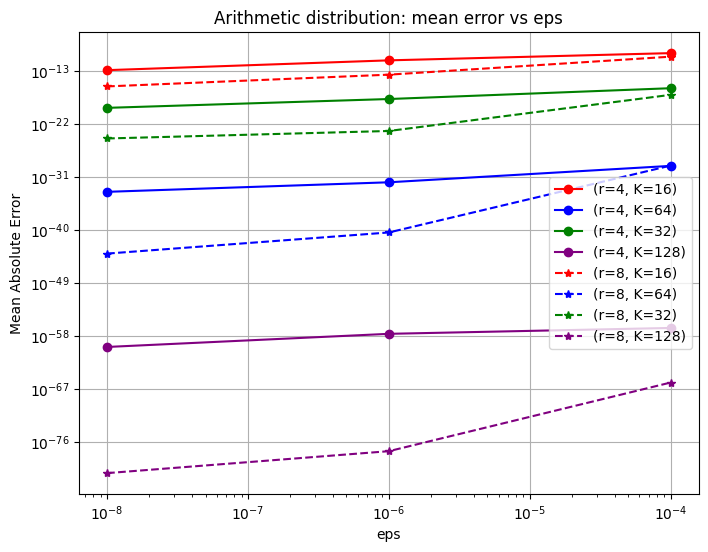

In [4]:
main_A()

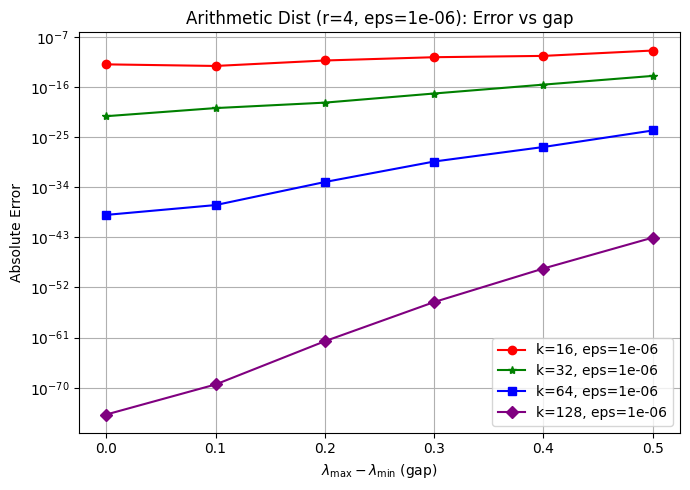

In [5]:
main_B()